In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')

C:\Users\Gavade\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
data_path = 'D:/My Works KG/Interview_preparation/Take_home_assessment/Data/Internet_data/'

In [3]:

dfs = []

for file_name in os.listdir(data_path):

    if file_name.endswith('.csv'):
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path)
        
        df.columns = df.columns.str.lower().str.replace(' ', '_')
        
        df = df.rename(columns={'service_provider' : 'operator','download' : 'download_upload','data_speed(kbps)' : 'speed','speed_kbps' : 'speed','lsa' : 'service_area'})
        
        df['file_name'] = file_name


        dfs.append(df)


combined_df = pd.concat(dfs, ignore_index=True)





In [4]:
combined_df.head()

,operator,technology,download_upload,speed,signal_strength,service_area,file_name
0,JIO,4G,download,1487.0,-97.0,Haryana,April_MySpeed-2020.csv
1,JIO,4G,download,1242.0,-94.0,Haryana,April_MySpeed-2020.csv
2,JIO,4G,download,9622.0,-92.0,Haryana,April_MySpeed-2020.csv
3,JIO,4G,download,837.0,-97.0,Haryana,April_MySpeed-2020.csv
4,JIO,4G,download,2047.0,-94.0,Haryana,April_MySpeed-2020.csv


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17777662 entries, 0 to 17777661
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   operator         object 
 1   technology       object 
 2   download_upload  object 
 3   speed            float64
 4   signal_strength  object 
 5   service_area     object 
 6   file_name        object 
dtypes: float64(1), object(6)
memory usage: 949.4+ MB


The dataset has 17777661 rows with total 7 columns and has size of about 949 MB.

### Statistical Analysis

In [6]:
# This funciton prepares summary of datasets separately for numerical variables, categorical variables, Outliere and Missing values

def get_summary(df, target_col=None):
    stats_df = df.copy()
    stats_num = stats_df.select_dtypes(exclude='object')
    desc_num = stats_num.describe()
    desc_num.reset_index(inplace=True)
    median_dict = desc_num.median().to_dict()
    median_dict['index'] = 'median'
    desc_num = desc_num.append(median_dict, ignore_index=True).round(2)
    if target_col:
        desc_num.drop(target_col, axis=1, inplace=True)
    desc_num.rename(columns={'index':'Statistical Measures'}, inplace=True)
    desc_num.set_index('Statistical Measures', inplace=True)
    desc_num.loc['count'] = desc_num.loc['count'].map(lambda x: "{0:.0f}".format(int(x)) if type(x) != str else x)

    stats_cat = stats_df.select_dtypes(include='object')
    desc_cat = stats_cat.describe()
    desc_cat.reset_index(inplace=True)

    Q1 = stats_num.quantile(0.25)
    Q3 = stats_num.quantile(0.75)
    IQR = Q3 - Q1
    outlier_df = ((stats_num < (Q1 - 1.5 * IQR)) | (stats_num > (Q3 + 1.5 * IQR))).sum().reset_index()
    outlier_df.rename(columns={'index': 'Feature', 0: 'Number of outliers'}, inplace=True)
    null_df = stats_num.isnull().sum().reset_index()
    null_df.rename(columns={'index': 'Feature', 0: 'null_values'}, inplace=True)
    null_df = null_df[null_df['null_values'] > 0]
    null_df['prop_null_values'] = ((null_df['null_values'] / len(stats_num)) * 100)
    null_df_40 = null_df[null_df['prop_null_values'] > 40]
    return {'summary_num': desc_num,'summary_cat':desc_cat, 'outlier_df': outlier_df, 'null_df': null_df,'null_df_40' : null_df_40}


In [7]:
summary_df = get_summary(combined_df)

In [16]:
summary_df['summary_num']

,speed
Statistical Measures,
count,16672850
mean,10371.46
std,15690.42
min,0.0
25%,1202.0
50%,4493.0
75%,12002.0
max,149894.0
median,11186.73


In [8]:
summary_df['summary_cat']

,index,operator,technology,download_upload,signal_strength,service_area,file_name
0,count,17777662,17777662,17777662,16841100,10660372,17777662
1,unique,8,2,2,127,23,34
2,top,JIO,4G,download,na,Maharashtra,MyCall_Data_January_2023.csv
3,freq,9402652,17338942,8893408,1083836,1142063,978070


In [9]:
summary_df['outlier_df']

,Feature,Number of outliers
0,speed,1577709


In [10]:
summary_df['null_df']

,Feature,null_values,prop_null_values
0,speed,1104812,6.214608


### Univariate Analysis

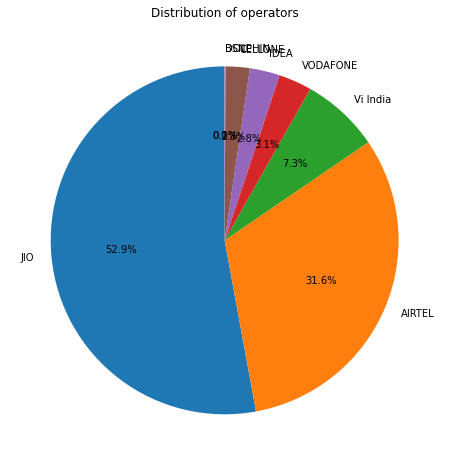

In [11]:
operator_counts = combined_df['operator'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(operator_counts, labels=operator_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of operators')
plt.show()

<AxesSubplot:xlabel='technology', ylabel='count'>

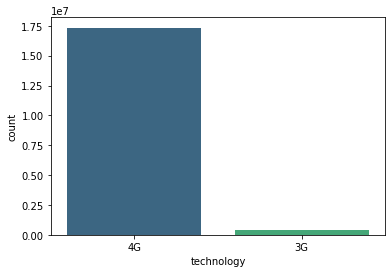

In [12]:
sns.countplot(data=combined_df, x='technology',palette='viridis')

In [26]:
combined_df['speed'].describe()

count    1.667285e+07
mean     1.037146e+04
std      1.569042e+04
min      0.000000e+00
25%      1.202000e+03
50%      4.493000e+03
75%      1.200200e+04
max      1.498940e+05
Name: speed, dtype: float64

In [25]:
combined_df['signal_strength'].value_counts(normalize=True)

na       0.064357
-90      0.045703
-97      0.020730
-103     0.019612
-105     0.019511
           ...   
-54      0.000211
-50      0.000073
-54.0    0.000053
-52.0    0.000037
-50.0    0.000015
Name: signal_strength, Length: 127, dtype: float64

In [24]:
signal_df.sort_values(by='proportion',ascending=False)

,signal_strength,proportion
0,na,0.064357
1,-90,0.045703
2,-97,0.020730
3,-103,0.019612
4,-105,0.019511
...,...,...
122,-54,0.000211
123,-50,0.000073
124,-54.0,0.000053
125,-52.0,0.000037


### Bivariate analysis

#### Operator and speed analysis

In [13]:
op_speed_df = combined_df.groupby('operator')['speed'].mean().reset_index().sort_values(by='speed',ascending=False)

In [14]:
op_speed_df

,operator,speed
5,JIO,12448.590468
7,Vi India,11092.850179
0,AIRTEL,8145.575332
6,VODAFONE,6799.207839
4,IDEA,6295.798873
3,DOLPHIN,4017.216667
2,CELLONE,2240.261215
1,BSNL,NaN


<AxesSubplot:xlabel='operator', ylabel='speed'>

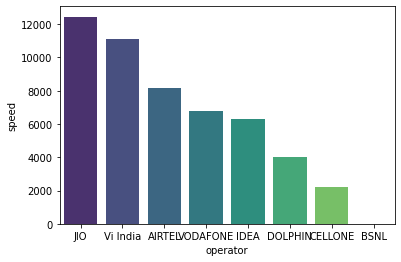

In [15]:
sns.barplot(data=op_speed_df, x='operator',y='speed',palette='viridis')

Among the operators JIO has highest average speed on 12000 kbps followed by Vi india and Airtel.

In [30]:
def num_cat_analysis(df, col_name, target):
    x1 = df.groupby(by=target)[col_name].aggregate(['mean','median', p75, p90])
    fig = sns.boxplot(x=target, y = col_name, data=df)
    return x1

def p75(x):
    return x.quantile([0.75])


def p90(x):
    return x.quantile([0.9])

,mean,median,p75,p90
operator,,,,
AIRTEL,8145.575332,3535.0,10457.0,22400.0
JIO,12448.590468,5518.0,14109.0,35025.0
Vi India,11092.850179,6604.0,15265.0,27749.0


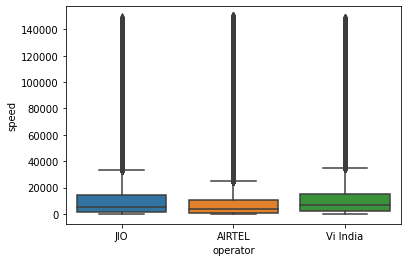

In [31]:
df_1 = num_cat_analysis(combined_df[combined_df['operator'].isin(['JIO','Vi India','AIRTEL'])], 'speed','operator')
df_1

#### Jio is outperforming all other operators in internet speed

#### Technology wise speed distribution

,mean,median,p75,p90
technology,,,,
3G,1878.803393,1245.0,2259.0,4377.0
4G,10585.350046,4691.0,12385.0,27623.0


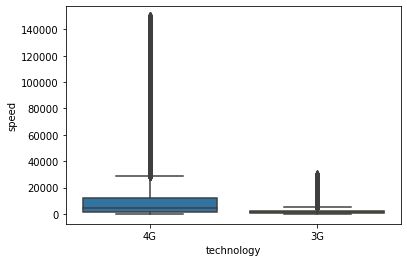

In [34]:
df_2 = num_cat_analysis(combined_df, 'speed','technology')
df_2

4G has far more speed than 3G which is obvious

### Mode(download/upload) wise speed analysis

,mean,median,p75,p90
download_upload,,,,
download,15648.979537,7996.0,20604.0,41048.0
upload,5088.801027,2608.0,7102.0,12391.0


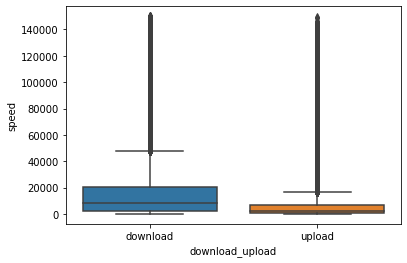

In [35]:
df_3 = num_cat_analysis(combined_df, 'speed','download_upload')
df_3

Download speed is higher than upload. 

### Multivariate analysis

In [38]:
pd.options.display.float_format = '{:.0f}'.format

In [39]:
# This function uses pivot talbe to draw impact of two categorical columns on third column.

def pivot_table(df, values, index, columns):
    xxx = pd.pivot_table(df, values=values, index=index,
                         columns=columns, aggfunc='mean')
    title = index.title() + ' vs' + columns.title() + ' wrt ' + values.title()
    plt.figure(figsize=(8, 8))
    fig = sns.heatmap(xxx, annot=True,cmap='RdBu_r',linecolor="yellow",linewidths=2)
    fig.set(title=title)
    plt.xlabel(columns)
    plt.ylabel(index)
    plt.show()
    
    plt.figure(figsize=(16, 14))
    title1 = index.title() + ' vs' + columns.title() + ' wrt ' + values.title()
#     plt.figure(figsize=(8, 8))
    fig1 = pd.pivot_table(df, values=values, index=index,
                        columns=columns, aggfunc='count').plot.bar()
    fig1.set(title=title1)                    
    plt.xlabel(index)
    plt.ylabel(columns)
    plt.show()


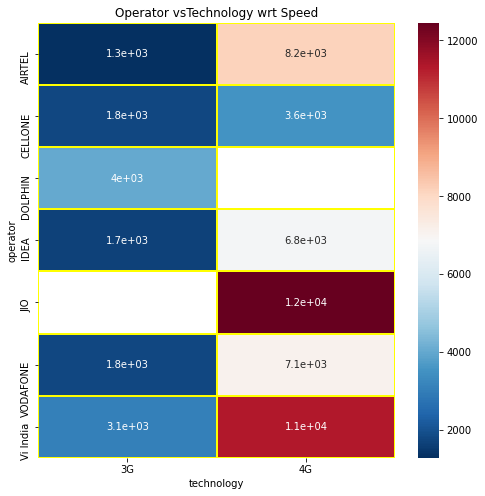

<Figure size 1152x1008 with 0 Axes>

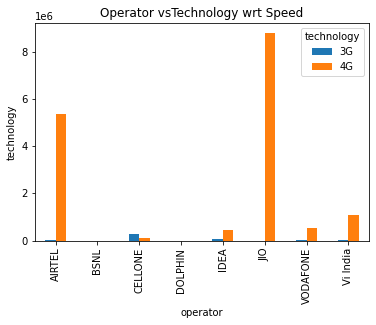

In [40]:
pivot_table(combined_df, 'speed','operator', 'technology')

#### relation between operator and mode(download/uploda) on speed

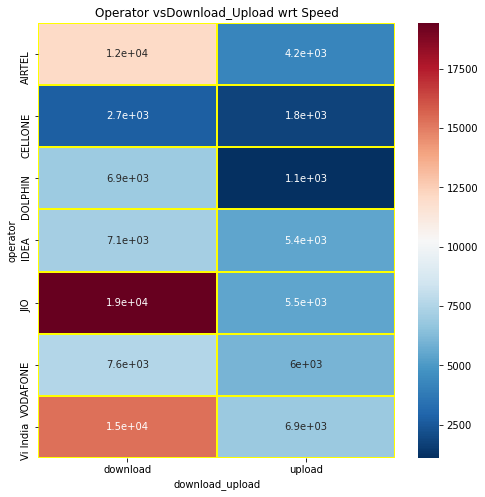

<Figure size 1152x1008 with 0 Axes>

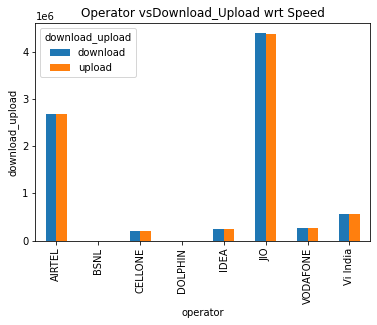

In [41]:
pivot_table(combined_df, 'speed','operator', 'download_upload')